In [1]:
from data_preprocessing.cleaning import clean_audio_folder
from data_preprocessing.augmentation import augment_audio_files
from data_preprocessing.merging import merge_audios_by_speakers
from data_preprocessing.splitting import split_audio_files
from data_preprocessing.spectrogram_converter import convert_audio_files_to_images
from data_preprocessing.spectrogram_sharpener import sharpen_spectrograms

C:\Users\micha\.virtualenvs\intro-to-ml-venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [9]:
import glob
from math import sqrt
import re
from typing import Dict, List

from matplotlib import pyplot as plt
from tqdm import tqdm


files = glob.glob("../data/v3/audio/**/*.wav", recursive=True)
files_string = "\n".join(files)
word_speaker_to_files: Dict[str, List[str]] = {}



for file in tqdm(files):
    word = file.split("\\")[-2]
    speaker = file.split("\\")[-1].split(".")[-2].split("_")[0]

    word_speaker_key = f"{word}_{speaker}"

    if word_speaker_key in word_speaker_to_files:
        continue

    word_speaker_files = re.findall(rf'{word}\\{speaker}', files_string)
    word_speaker_to_files[word_speaker_key] = len(word_speaker_files)

file_occurances = [files_count for files_count in word_speaker_to_files.values()]

100%|██████████████████████████████████████████████████████████████████████████| 64727/64727 [00:40<00:00, 1597.94it/s]


Text(0.5, 0, 'Count of different versions of same audio')

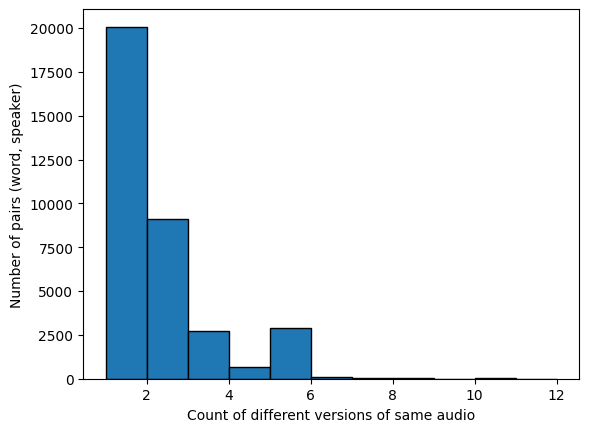

In [4]:
plt.hist(file_occurances, bins=11, edgecolor='black')
plt.ylabel('Number of pairs (word, speaker)')
plt.xlabel('Count of different versions of same audio')

In [8]:
file_occurances

[]

In [5]:
import numpy as np


values, bins = np.histogram(file_occurances, bins=11)
print(values)
print(bins)

[20073  9080  2726   668  2902    80    31    24     8    15     2]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


(array([ 38.,   0.,  13.,   0.,  10.,   0.,  13.,   0.,   7.,   0.,  11.,
          0.,   8.,   0.,   7.,   0.,   6.,   0.,   7.,   0.,   8.,   0.,
          9.,   0.,   9.,   0.,  12.,   0.,  26.,   0.,   0.,  79.,   0.,
        162.,   0., 260.,   0., 385.,   0., 310.,   0., 223.,   0.,  88.,
          0.,  32.,   0.,   3.,   0.,   1.,   0.,   4.,   0.,   3.,   0.,
          1.,   0.,   9.,   0., 137.]),
 array([ 2.        ,  2.96666667,  3.93333333,  4.9       ,  5.86666667,
         6.83333333,  7.8       ,  8.76666667,  9.73333333, 10.7       ,
        11.66666667, 12.63333333, 13.6       , 14.56666667, 15.53333333,
        16.5       , 17.46666667, 18.43333333, 19.4       , 20.36666667,
        21.33333333, 22.3       , 23.26666667, 24.23333333, 25.2       ,
        26.16666667, 27.13333333, 28.1       , 29.06666667, 30.03333333,
        31.        , 31.96666667, 32.93333333, 33.9       , 34.86666667,
        35.83333333, 36.8       , 37.76666667, 38.73333333, 39.7       ,
      

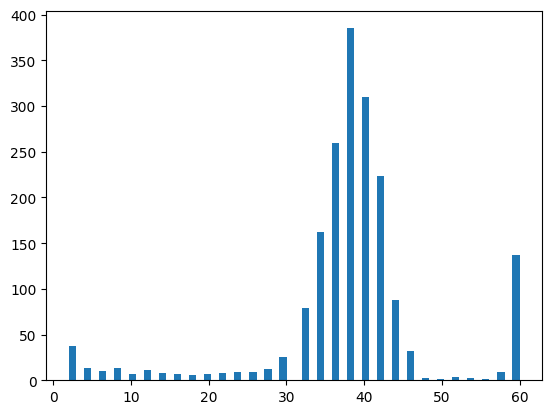

In [12]:
import glob
from typing import Dict, List

from matplotlib import pyplot as plt

files = glob.glob("../data/v3/**/*_nohash_0.wav", recursive=True)
word_speaker_to_files: Dict[str, List[str]] = {}

for file in files:
    hash_id = file.split("\\")[-1].split("_")[-3]
    if hash_id not in word_speaker_to_files:
        word_speaker_to_files[hash_id] = []
    word_speaker_to_files[hash_id].append(file)


file_occurances = [len(files) for files in word_speaker_to_files.values()]
plt.hist(file_occurances, bins=60)

In [10]:
import random
import numpy as np
from data_preprocessing.train_test_split import train_test_split

random.seed(42)
np.random.seed(42)

train_test_split_files(
    '../data/v3/audio', 
    '../data/v3/train', 
    '../data/v3/test', 
    '../data/v3/validation'
)

In [19]:
#augment_audio_files('../data/v3/tsrc_train_test', '../data/v3/tsrc_augmented')
clean_audio_folder('../data/v3/tsrc_train_test', '../data/v3/tsrc_cleaned')
merge_audios_by_speakers('../data/v3/tsrc_cleaned', '../data/v3/tsrc_merged')
split_audio_files('../data/v3/tsrc_merged', '../data/v3/tsrc_splitted')
convert_audio_files_to_images("../data/v3/tsrc_splitted", "../data/v3/tsrc_sprectrograms")

Cleaning audio files for train data...


100%|██████████████████████████████████████████████████████████████████████████████| 1104/1104 [00:27<00:00, 40.41it/s]


Cleaning audio files for test data...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 38.53it/s]


Cleaning audio files for validation data...


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 35.94it/s]


Merging audio files by speaker for train data...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.95it/s]


Merging audio files by speaker for test data...


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 114.29it/s]


Merging audio files by speaker for validation data...


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 110.40it/s]


Splitting audio files for train data...


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.89it/s]


Splitting audio files for test data...


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 339.13it/s]


Splitting audio files for validation data...


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 246.99it/s]


Converting audio files to images for train data...


100%|████████████████████████████████████████████████████████████████████████████████| 285/285 [00:34<00:00,  8.20it/s]


Converting audio files to images for test data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]


Converting audio files to images for validation data...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]
